In [52]:
import numpy as np
import os
import cv2
import mediapipe as mp
import subprocess
import csv
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.layers import Input,Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae_func, mean_squared_error
from sklearn import preprocessing
mp_selfie_segmentation = mp.solutions.selfie_segmentation
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2

In [11]:
# print(cv2.getBuildInformation())

In [12]:
video_directory = "E:\\course_work\\Dissertation\\back"

videos = []

for dirpath, dirnames, filenames in os.walk(video_directory):
    video_files = [file for file in filenames if file.endswith('.mkv')]
    for video_file in video_files:
        video_file_path = os.path.join(dirpath, video_file)
        output_file_path = os.path.splitext(video_file_path)[0] + '.mp4'
        subprocess.run(['ffmpeg', '-i', video_file_path, output_file_path])
        videos.append(output_file_path)


In [13]:
  
output_folder = "E:\\course_work\\Dissertation\\pose_estim\\" 
output_extension = ".mp4"

# Set the video writer parameters
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Specify the video codec (e.g., "mp4v" for MP4)

frame_size = (1280, 720)



# Estimation Keypoint

<img src="https://www.mdpi.com/applsci/applsci-13-02700/article_deploy/html/images/applsci-13-02700-g001.png" style="height=200px" >

# Jumping

In [14]:
def calculate_vertical_displacement(a, b):
    """Calculate the vertical displacement between points a and b"""
    return b - a

# Squating

In [15]:
def calculate_angle(a, b, c):
    """Calculate the angle between points a, b, and c"""
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    #cosine_angle = np.clip(cosine_angle, -1, 1)
    angle = np.arccos(cosine_angle)
    
    return np.degrees(angle)

In [16]:
os.makedirs(output_folder, exist_ok=True)
csv_file = open("output.csv", mode='w', newline='')  # Set newline='' to avoid extra empty rows
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['video_path', 'action', 'hip_knee_angle', 'shoulder_hip_angle', 'shoulder_angle', 'elbow_angle','avg_hip_angle', 'avg_shoulder_angle', 'avg_knee_angle'])

feet_together = False

with mp_pose.Pose(min_detection_confidence=0.8 , min_tracking_confidence=0.8) as pose,mp_selfie_segmentation.SelfieSegmentation(model_selection=0) as selfie_segmentation:
    for vid in videos:
        video = cv2.VideoCapture(vid)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        squat_detected = False
        jump_detected = False
        baseline = None
        jump_threshold = 0.015
        filename = os.path.splitext(os.path.basename(vid))[0]
        output_path = os.path.join(output_folder, filename + output_extension)
        original_fps = video.get(cv2.CAP_PROP_FPS)
        original_frame_size = (
            int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        )
        video_writer = cv2.VideoWriter(output_path, fourcc, original_fps, frame_size)
        hip_knee_angles = []
        shoulder_hip_angles = []
        shoulder_angles = []
        elbow_angles = []
        foot_y_positions = []
        avg_hip_angle = 0.0
        avg_shoulder_angle = 0.0
        avg_knee_angle = 0.0
        frame_count = 0
        feet_off_floor = False
        feet_landed = False
        while True:
            ret,frame = video.read()
            if not ret:
                break

            resized_frame = cv2.resize(frame, frame_size)
            image = cv2.cvtColor(resized_frame,cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            segmentation_results = selfie_segmentation.process(image)
            image.flags.writeable = True
            
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark

                # Squating
                right_hip = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y])
                right_knee = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y])
                left_knee = np.array([landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y])
                right_shoulder = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y])
                left_shoulder = np.array([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y])
                left_hip = np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y])
                right_elbow = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y])
                right_wrist = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y])
                right_foot_y = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y
                left_foot_y = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y
                right_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y
                left_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y
                
                # Calculate angles
                elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
                hip_knee_angle = calculate_angle(right_hip, right_knee, left_knee)
                shoulder_hip_angle = calculate_angle(right_shoulder, right_hip, left_hip)
                shoulder_angle = calculate_angle(right_shoulder, left_shoulder, right_hip)
                
                
                hip_knee_angles.append(hip_knee_angle)
                shoulder_hip_angles.append(shoulder_hip_angle)
                shoulder_angles.append(shoulder_angle)
                elbow_angles.append(elbow_angle)
                avg_hip_angle += hip_knee_angle
                avg_shoulder_angle += shoulder_hip_angle
                avg_knee_angle += shoulder_angle
    
                
                # Detect squats
                squat_condition1 = hip_knee_angle < 110
                squat_condition2 = shoulder_hip_angle < 130
                squat_condition3 = shoulder_angle < 70
                squat_condition4 = elbow_angle > 90
                squat_condition5 = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y >= landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y
                squat_condition6 = landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y >= landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y
                if squat_condition1 and squat_condition2 and squat_condition3 and squat_condition4 and squat_condition5 and squat_condition6:  # Ensuring heels are grounded
                    squat_detected = True
                
            
                # Jumping

                hip_y = (landmarks[27].y + landmarks[28].y) / 2
    
                if baseline is None:
                    baseline = hip_y
                else:
                    # Calculate the distance of the hips from the baseline
                    hip_distance = calculate_vertical_displacement(baseline,hip_y)

                    if hip_distance > jump_threshold :
                        jump_detected = True
                        
                    baseline = hip_y
                    

                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                #Frame Normalization
                landmarks_array = np.array([(lmk.x, lmk.y, lmk.z) for lmk in landmarks])
                # Normalize the landmarks
                mean = np.mean(landmarks_array, axis=0)
                std = np.std(landmarks_array, axis=0)
                normalized_landmarks = (landmarks_array - mean) / std

            condition = np.stack((segmentation_results.segmentation_mask,) * 3, axis=-1) > 0.1
            # this two will blurred background 
            blurred_image = cv2.GaussianBlur(image, (99, 99), 30)
            output_image = np.where(condition, image, blurred_image)

            # this below lines change background to green color
            # background_color = np.zeros_like(image)
            # background_color[:] = [0, 255, 0]  # Green in BGR
            # output_image = np.where(condition, image, background_color)
            
            frame_count += 1

            video_writer.write(output_image)
            
        hip_knee_angle = np.mean(hip_knee_angles)
        shoulder_hip_angle = np.mean(shoulder_hip_angles)
        shoulder_angle = np.mean(shoulder_angles)
        elbow_angle = np.mean(elbow_angles)
        
        if frame_count > 0:
            avg_hip_angle /= frame_count
            avg_shoulder_angle /= frame_count
            avg_knee_angle /= frame_count
        else:
            # Assign default values if no frames were processed
            avg_hip_angle = 0.0
            avg_shoulder_angle = 0.0
            avg_knee_angle = 0.0
            
        if squat_detected and not jump_detected:
            action = "Squat"
            print(f"Squat detected in video: {vid}")
        elif jump_detected and squat_detected:
            action= "Jump"
            print(f"Jump detected in video: {vid}")
        else:
            action='None'
        csv_writer.writerow([output_path, action, hip_knee_angle, shoulder_hip_angle, shoulder_angle, elbow_angle,avg_hip_angle,avg_shoulder_angle,avg_knee_angle])
        # else:
        #     print(f"nothing detected in video: {vid}")
        video.release()
        video_writer.release()
csv_file.close()



Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094505.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094600.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094626.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094649.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094705.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094722.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094739.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094754.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094811.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094826.mp4
Squat dete

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Squat detected in video: E:\course_work\Dissertation\back\back_003\back_003_m01_20230224101043.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_003\back_003_m01_20230224101126.mp4
Jump detected in video: E:\course_work\Dissertation\back\back_003\back_003_m01_20230224101148.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_003\back_003_m01_20230224101235.mp4
Squat detected in video: E:\course_work\Dissertation\back\back_003\back_003_m01_20230224101254.mp4
Jump detected in video: E:\course_work\Dissertation\back\back_003\back_003_m02_20230224101521.mp4
Jump detected in video: E:\course_work\Dissertation\back\back_003\back_003_m02_20230224101610.mp4
Jump detected in video: E:\course_work\Dissertation\back\back_003\back_003_m02_20230224101629.mp4
Jump detected in video: E:\course_work\Dissertation\back\back_003\back_003_m02_20230224101648.mp4
Jump detected in video: E:\course_work\Dissertation\back\back_003\back_003_m02_20230224101708.mp4
Jump detected in

In [ ]:


# average_foot_y = (right_foot_y + left_foot_y) / 2
                    #     foot_y_positions.append(average_foot_y)
                    #     if len(foot_y_positions) > 2:
                    #         prev_pos1 = foot_y_positions[-3]
                    #         prev_pos2 = foot_y_positions[-2]
                    #         curr_pos = foot_y_positions[-1]
                    #         print(prev_pos1)
                    #         print(prev_pos)
                            

                    # # Check if both feet were previously on the floor and are now off the floor
                    #         if prev_pos1 < prev_pos2 and curr_pos < prev_pos2:
                    #             feet_off_floor = True

                    #         if prev_pos1 > prev_pos2 and curr_pos > prev_pos2 and feet_off_floor:
                    #             feet_landed = True

                    #         if feet_off_floor and feet_landed:
                    #             feet_together = True


# Neural Network Models

In [33]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold

In [34]:
# Read the CSV file
data = pd.read_csv('output.csv')

data  = data.dropna()

In [35]:
data['action'].value_counts()

Squat    88
Jump     87
None     36
Name: action, dtype: int64

In [36]:
data['score'].value_counts()

1    91
2    68
3    46
4     5
0     1
Name: score, dtype: int64

In [6]:
data.describe()

,hip_knee_angle,shoulder_hip_angle,shoulder_angle,elbow_angle,avg_hip_angle,avg_shoulder_angle,avg_knee_angle,score
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,118.004484,94.247549,73.957344,143.918603,116.631937,93.182199,73.143182,1.824645
std,10.224770,8.967830,8.102741,16.499857,12.074119,10.476290,9.231244,0.857771
min,83.076706,67.549588,53.758725,85.741138,51.581812,40.414737,30.916034,0.000000
25%,110.962731,89.520853,68.775344,133.665980,109.661609,88.981450,67.950402,1.000000
50%,116.432574,93.363725,72.913359,146.538353,115.203941,92.913339,72.716553,2.000000
75%,124.148618,97.055824,79.057986,156.851272,123.973253,96.655024,78.556260,2.000000
max,142.546282,137.017490,111.942373,168.693061,141.712679,137.017490,111.942373,4.000000


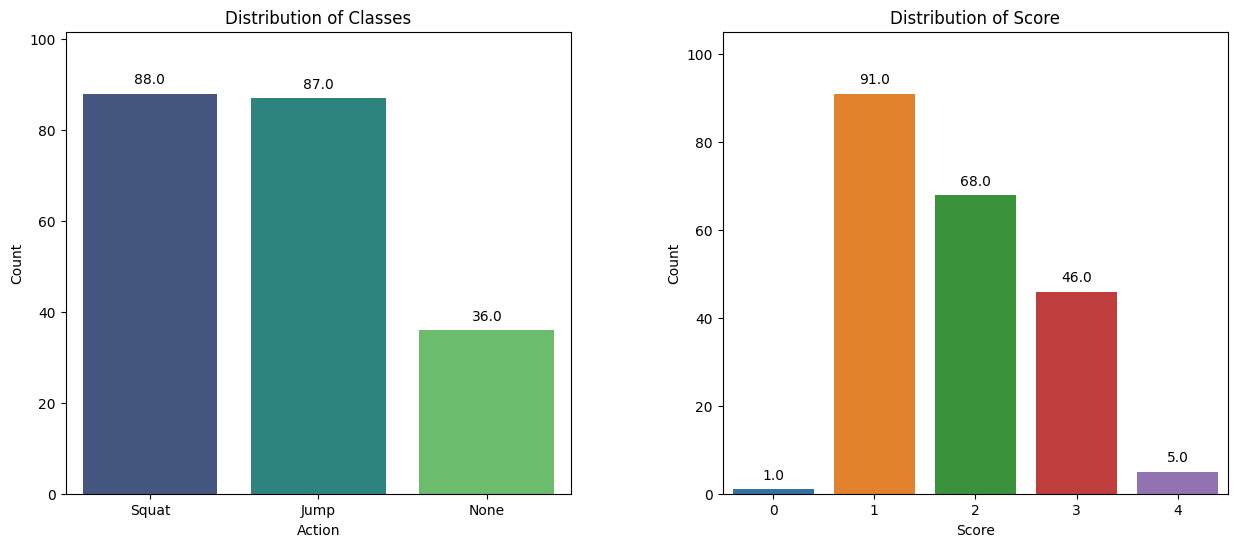

In [7]:
# Create a figure and set its size
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot for action
ax = sns.countplot(data=data, x='action', palette="viridis", ax=axs[0])
ax.set_title("Distribution of Classes")
ax.set_xlabel("Action")
ax.set_ylabel("Count")
y_max = ax.get_ylim()[1]
ax.set_ylim([0, y_max*1.1])  # Increase y-axis limit
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Second subplot for score
ay = sns.countplot(data=data, x='score', ax=axs[1])
ay.set_title("Distribution of Score")
ay.set_xlabel("Score")
ay.set_ylabel("Count")
y_max = ay.get_ylim()[1]
ay.set_ylim([0, y_max*1.1])  # Increase y-axis limit
for p in ay.patches:
    ay.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Adjust space between plots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()


In [37]:
# Read the CSV file
df = pd.read_csv('output_final.csv')

df  = df.dropna()

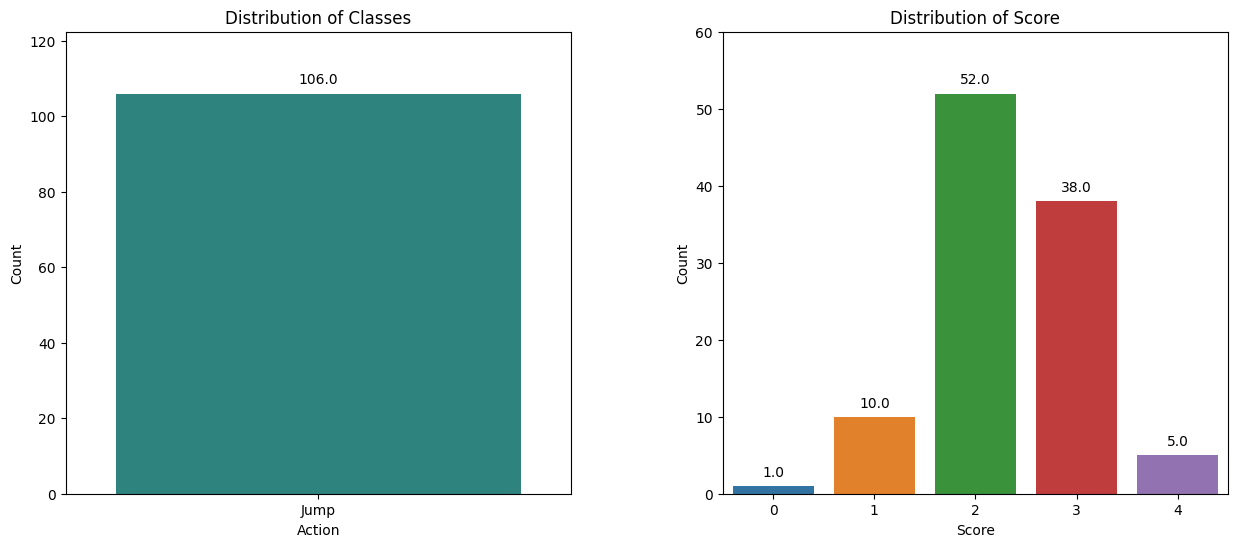

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot for action
ax = sns.countplot(data=df, x='action', palette="viridis", ax=axs[0])
ax.set_title("Distribution of Classes")
ax.set_xlabel("Action")
ax.set_ylabel("Count")
y_max = ax.get_ylim()[1]
ax.set_ylim([0, y_max*1.1])  # Increase y-axis limit
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Second subplot for score
ay = sns.countplot(data=df, x='score', ax=axs[1])
ay.set_title("Distribution of Score")
ay.set_xlabel("Score")
ay.set_ylabel("Count")
y_max = ay.get_ylim()[1]
ay.set_ylim([0, y_max*1.1])  # Increase y-axis limit
for p in ay.patches:
    ay.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Adjust space between plots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()

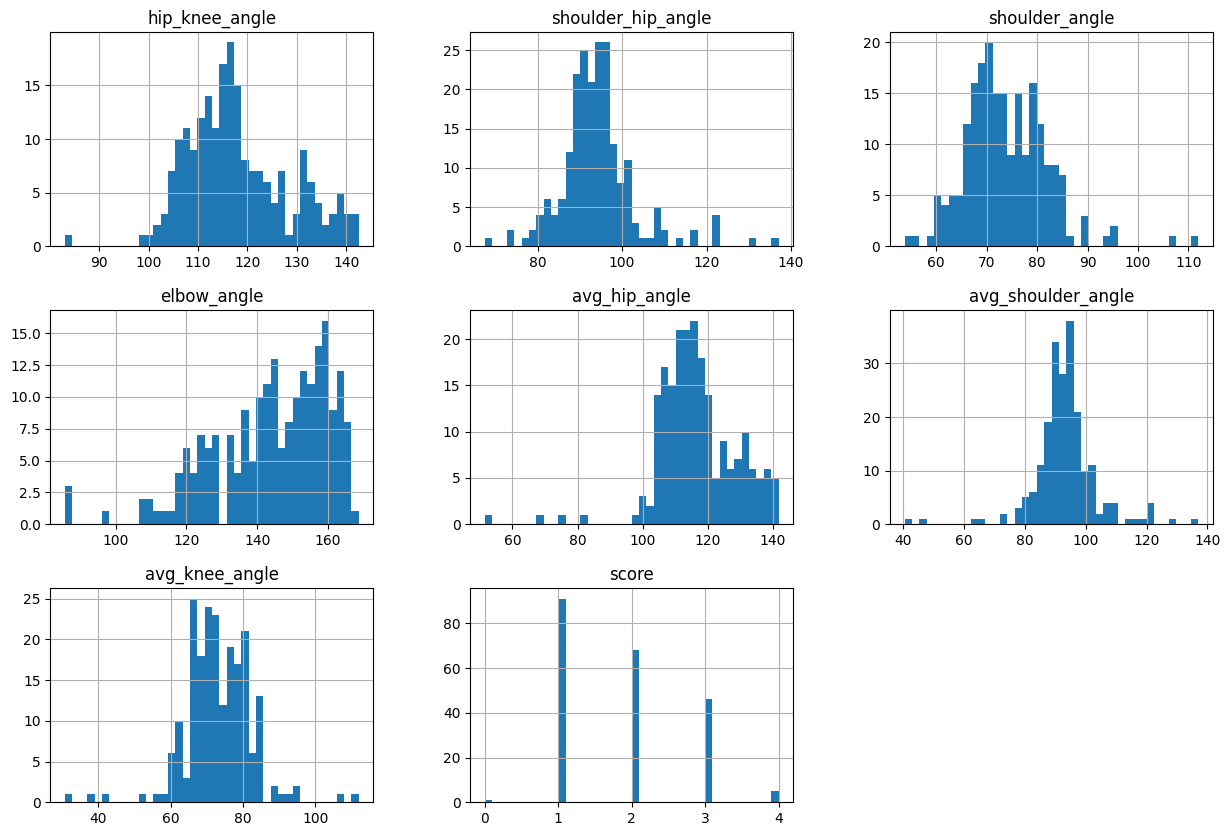

In [39]:
data.hist(bins=40, figsize=(15, 10))
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_9912\1464034413.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


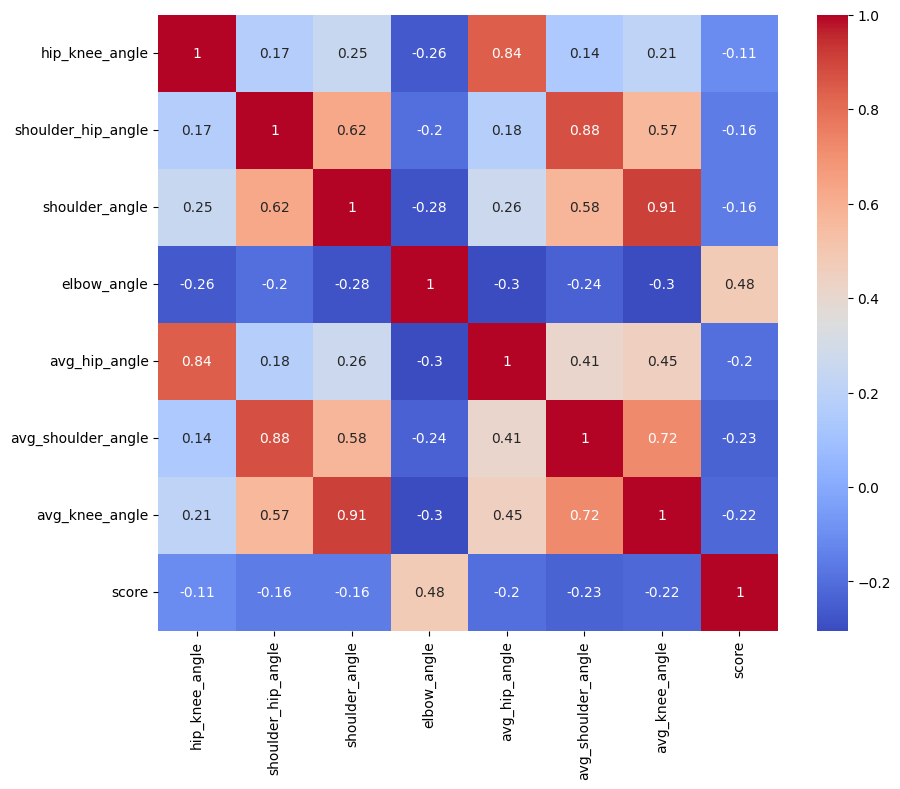

In [40]:
corr = data.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

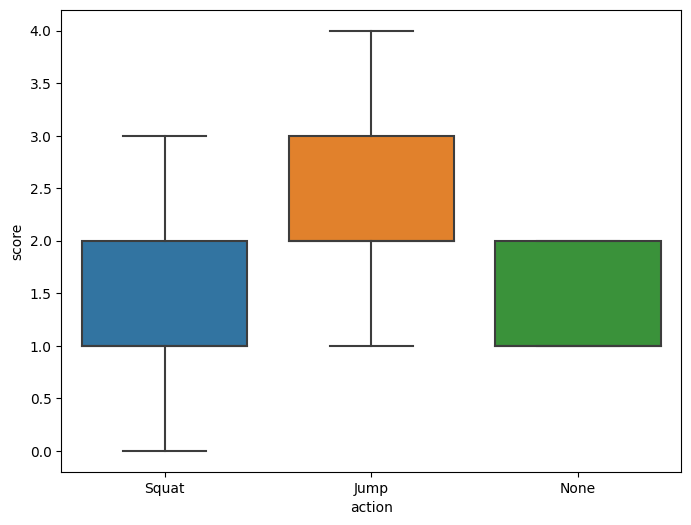

In [41]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data, x='action', y='score')
plt.show()

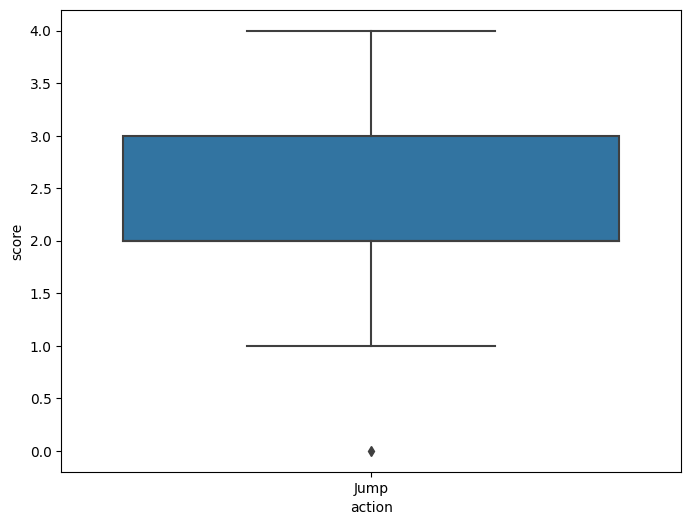

In [42]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='action', y='score')
plt.show()

In [43]:
label_encoder = preprocessing.LabelEncoder()
df['action']= label_encoder.fit_transform(df['action'])

In [44]:
df.head()

,video_path,action,hip_knee_angle,shoulder_hip_angle,shoulder_angle,elbow_angle,avg_hip_angle,avg_shoulder_angle,avg_knee_angle,score
0,E:\course_work\Dissertation\pose_estim\back_00...,0,114.927867,94.337725,79.915622,140.483815,114.450988,93.946282,79.584022,2
1,E:\course_work\Dissertation\pose_estim\back_00...,0,113.522804,91.478660,70.817501,144.805939,113.522804,91.478660,70.817501,2
2,E:\course_work\Dissertation\pose_estim\back_00...,0,112.051170,94.470391,74.901740,144.604671,111.634623,94.119200,74.623295,3
3,E:\course_work\Dissertation\pose_estim\back_00...,0,112.306939,94.145046,71.816151,137.345489,111.812194,93.730310,71.499780,3
4,E:\course_work\Dissertation\pose_estim\back_00...,0,112.071483,91.388018,69.498396,140.523180,111.171311,90.653977,68.940176,2


In [45]:
df = df.drop(df[(df['score'] == 4) | (df['score'] == 0)].index)

In [46]:
df.shape

(100, 10)

In [47]:
import cv2
import numpy as np

def preprocess_video(video_path, frame_size=(64, 64), num_frames=30):
    # Initialize a list to hold frames
    frames = []

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the middle frame number
    middle_frame = total_frames // 2

    # Calculate the start frame number
    start_frame = max(0, middle_frame - num_frames // 2)

    # Set the video to start at the start_frame
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while True:
        # Read a frame from the video
        ret, frame = video.read()

        # If the frame was successfully read
        if ret:
            # Resize the frame
            frame = cv2.resize(frame, frame_size)

            # Normalize pixel values
            frame = frame / 255.0

            # Add the frame to the list
            frames.append(frame)
        else:
            # If no frame was read then we've reached the end of the video
            break

        # If we've collected enough frames then we can stop reading the video
        if len(frames) == num_frames:
            break

    video.release()

    # Stack frames into a single numpy array
    frames = np.stack(frames)

    return frames



In [48]:


# Preprocess videos
video_X = np.array([preprocess_video(vp) for vp in df['video_path']])

angle_X = df[['hip_knee_angle', 'shoulder_hip_angle', 'shoulder_angle', 'elbow_angle','avg_hip_angle', 'avg_shoulder_angle', 'avg_knee_angle','action']].values


# Convert the scores to a numpy array
y = df['score'].values
y_adjusted = y-1

In [49]:
video_X_train, video_X_test, angle_X_train, angle_X_test, y_train, y_test = train_test_split(video_X, angle_X, y_adjusted, test_size=0.2, random_state=42)

# smote = SMOTE(random_state=42)


# # Step 2: Apply SMOTE to video_X_train and y_train
# video_X_train, y_train = smote.fit_resample(video_X_train, y_train)

# # Step 3: Apply SMOTE to angle_X_train and y_train
# angle_X_train, y_train = smote.fit_resample(angle_X_train, y_train)


# Define the model
num_frames = video_X_train.shape[1]
frame_height = video_X_train.shape[2]
frame_width = video_X_train.shape[3]
num_channels = video_X_train.shape[4]
num_angles = angle_X_train.shape[1]

In [51]:
video_X_train[0].shape

(30, 64, 64, 3)

In [50]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))
x = Conv3D(32, (3, 3, 3), activation='relu')(video_input)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(x)

In [22]:
# Angles branch
angles_input = Input(shape=(num_angles,))
y = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(angles_input)

In [23]:
combined = Concatenate()([x, y])

In [24]:
# combined outputs
z = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(combined)
z = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(z)
score_output = Dense(3, activation='softmax')(z)

In [25]:
model = Model(inputs=[video_input, angles_input], outputs=score_output)

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit([video_X_train, angle_X_train], y_train, validation_data=([video_X_test, angle_X_test], y_test), epochs=10, batch_size=32)


# Evaluate the model
loss, accuracy  = model.evaluate([video_X_test, angle_X_test], y_test)
predictions = model.predict([video_X_test, angle_X_test])


print("Accuracy: {:.4f}".format(accuracy))



Epoch 1/10
6/6 [==============================] - 66s 10s/step - loss: 25.0066 - accuracy: 0.2683 - val_loss: 7.4351 - val_accuracy: 0.5366
Epoch 2/10
6/6 [==============================] - 60s 10s/step - loss: 6.0975 - accuracy: 0.2866 - val_loss: 4.6072 - val_accuracy: 0.5366
Epoch 3/10
6/6 [==============================] - 62s 10s/step - loss: 5.2598 - accuracy: 0.3293 - val_loss: 4.5064 - val_accuracy: 0.5854
Epoch 4/10
6/6 [==============================] - 59s 10s/step - loss: 4.7101 - accuracy: 0.5244 - val_loss: 4.4531 - val_accuracy: 0.7317
Epoch 5/10
6/6 [==============================] - 59s 10s/step - loss: 4.4273 - accuracy: 0.6037 - val_loss: 4.3102 - val_accuracy: 0.4878
Epoch 6/10
6/6 [==============================] - 60s 10s/step - loss: 4.0855 - accuracy: 0.6585 - val_loss: 4.0332 - val_accuracy: 0.5854
Epoch 7/10
6/6 [==============================] - 60s 10s/step - loss: 3.7900 - accuracy: 0.6463 - val_loss: 3.6250 - val_accuracy: 0.7073
Epoch 8/10
6/6 [==========

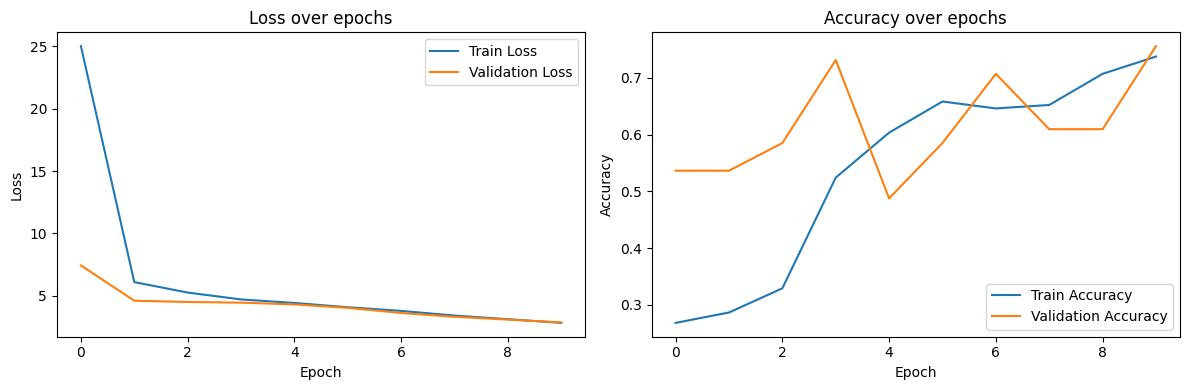

In [27]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Siamese network

In [28]:
# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Shared convolutional layers
    conv1 = Conv3D(32, (3, 3, 3), activation='relu')
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))
    flatten = Flatten()

    # Branch 1
    x1 = conv1(input_1)
    x1 = pool1(x1)
    x1 = flatten(x1)

    # Branch 2
    x2 = conv1(input_2)
    x2 = pool1(x2)
    x2 = flatten(x2)

    # Concatenate the outputs of the branches
    merged = Concatenate()([x1, x2])

    # Dense layers for final prediction
    x = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(merged)
    output = Dense(3, activation='softmax')(x)

    # Create the Siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    return siamese_model

In [29]:
input_shape = (num_frames, frame_height, frame_width, num_channels)

In [30]:
siamese_model = create_siamese_network(input_shape)

In [31]:
siamese_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
his = siamese_model.fit([video_X_train, video_X_train], y_train, epochs=10, batch_size=32, validation_data=([video_X_test, video_X_test], y_test))

Epoch 1/10
6/6 [==============================] - 98s 15s/step - loss: 33.4722 - accuracy: 0.3780 - val_loss: 6.1170 - val_accuracy: 0.5366
Epoch 2/10
6/6 [==============================] - 87s 14s/step - loss: 6.4032 - accuracy: 0.4451 - val_loss: 3.7933 - val_accuracy: 0.3171
Epoch 3/10
6/6 [==============================] - 86s 14s/step - loss: 3.6715 - accuracy: 0.6037 - val_loss: 3.6592 - val_accuracy: 0.7073
Epoch 4/10
6/6 [==============================] - 94s 15s/step - loss: 3.6412 - accuracy: 0.6890 - val_loss: 3.6557 - val_accuracy: 0.6829
Epoch 5/10
6/6 [==============================] - 80s 13s/step - loss: 3.5222 - accuracy: 0.7500 - val_loss: 3.6193 - val_accuracy: 0.7073
Epoch 6/10
6/6 [==============================] - 83s 14s/step - loss: 3.4691 - accuracy: 0.7317 - val_loss: 3.4580 - val_accuracy: 0.6341
Epoch 7/10
6/6 [==============================] - 90s 15s/step - loss: 3.1357 - accuracy: 0.8476 - val_loss: 5.6185 - val_accuracy: 0.1463
Epoch 8/10
6/6 [==========

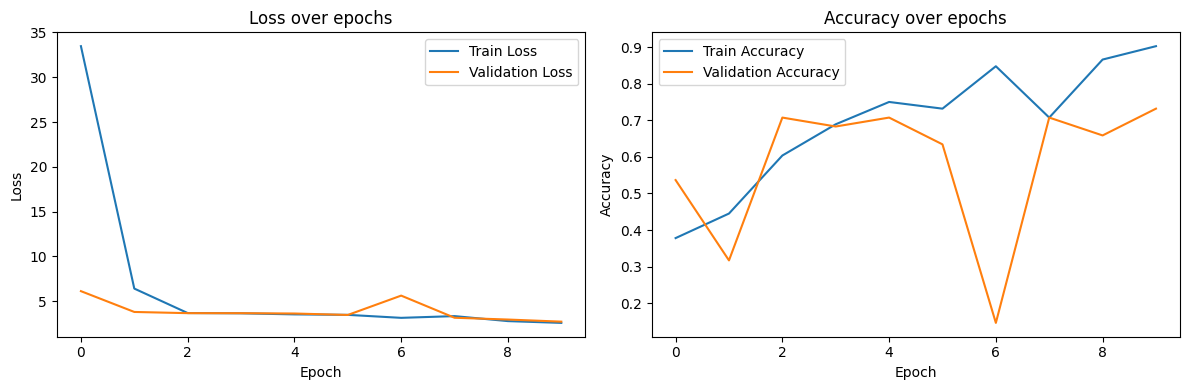

In [34]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(his.history['loss'], label='Train Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(his.history['accuracy'], label='Train Accuracy')
plt.plot(his.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
squat = pd.read_csv("squat.csv")

In [54]:
jump = pd.read_csv("jump.csv")

In [55]:

squat  = squat.dropna()
jump = jump.dropna()

In [56]:
squat = squat.drop(squat[(squat['score'] == 4) | (squat['score'] == 0)].index)
jump = jump.drop(jump[(jump['score'] == 4) | (jump['score'] == 0)].index)

In [57]:
squat = squat.drop(columns=['action'])
jump = jump.drop(columns=['action'])

In [58]:
squat.head(5)

,video_path,hip_knee_angle,shoulder_hip_angle,shoulder_angle,elbow_angle,avg_hip_angle,avg_shoulder_angle,avg_knee_angle,score
0,E:\course_work\Dissertation\pose_estim\back_00...,117.697025,91.127693,72.783544,139.490175,117.697025,91.127693,72.783544,1
1,E:\course_work\Dissertation\pose_estim\back_00...,113.846902,84.453334,68.322121,121.497361,113.846902,84.453334,68.322121,1
2,E:\course_work\Dissertation\pose_estim\back_00...,118.133967,87.339404,71.721216,123.083462,118.133967,87.339404,71.721216,1
3,E:\course_work\Dissertation\pose_estim\back_00...,116.450505,89.601532,69.835781,125.030470,116.450505,89.601532,69.835781,1
4,E:\course_work\Dissertation\pose_estim\back_00...,125.629365,83.857287,70.544274,116.678328,125.629365,83.857287,70.544274,1


In [59]:
jump.head()

,video_path,hip_knee_angle,shoulder_hip_angle,shoulder_angle,elbow_angle,avg_hip_angle,avg_shoulder_angle,avg_knee_angle,score
0,E:\course_work\Dissertation\pose_estim\back_00...,114.927867,94.337725,79.915622,140.483815,114.450988,93.946282,79.584022,2
1,E:\course_work\Dissertation\pose_estim\back_00...,113.522804,91.478660,70.817501,144.805939,113.522804,91.478660,70.817501,2
2,E:\course_work\Dissertation\pose_estim\back_00...,112.051170,94.470391,74.901740,144.604671,111.634623,94.119200,74.623295,3
3,E:\course_work\Dissertation\pose_estim\back_00...,112.306939,94.145046,71.816151,137.345489,111.812194,93.730310,71.499780,3
4,E:\course_work\Dissertation\pose_estim\back_00...,112.071483,91.388018,69.498396,140.523180,111.171311,90.653977,68.940176,2


In [60]:
squat.shape

(105, 9)

In [61]:
jump.shape

(100, 9)

In [62]:

# Preprocess videos
video_squat = np.array([preprocess_video(vp) for vp in squat['video_path']])

angle_squat = squat[['hip_knee_angle', 'shoulder_hip_angle', 'shoulder_angle', 'elbow_angle','avg_hip_angle', 'avg_shoulder_angle', 'avg_knee_angle']].values


# Convert the scores to a numpy array
y_squat = squat['score'].values
y_adjusted_squat = y_squat-1

In [63]:
video_squat_train, video_squat_test, angle_squat_train, angle_squat_test, squat_train, squat_test = train_test_split(video_squat, angle_squat, y_adjusted_squat, test_size=0.2, random_state=42)

In [64]:
num_frames = video_squat_train.shape[1]
frame_height = video_squat_train.shape[2]
frame_width = video_squat_train.shape[3]
num_channels = video_squat_train.shape[4]
num_angles = angle_squat_train.shape[1]

In [65]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))
x = Conv3D(16, (3, 3, 3), activation='relu')(video_input)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Flatten()(x)
x = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(x)

In [66]:
# Angles branch
angles_input = Input(shape=(num_angles,))
y = Dense(16, activation='relu',kernel_regularizer=l2(0.01))(angles_input)

In [67]:
combined = Concatenate()([x, y])

In [74]:
# combined outputs
z = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(combined)
score_output = Dense(3, activation='softmax',kernel_regularizer=l2(0.01))(z)

In [75]:
model = Model(inputs=[video_input, angles_input], outputs=score_output)

In [76]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit([video_squat_train, angle_squat_train], squat_train, validation_data=([video_squat_test, angle_squat_test], squat_test), epochs=50, batch_size=32)


# Evaluate the model
loss, accuracy  = model.evaluate([video_squat_test, angle_squat_test], squat_test)
predictions = model.predict([video_squat_test, angle_squat_test])


print("Accuracy: {:.4f}".format(accuracy))

Epoch 1/50
3/3 [==============================] - 29s 7s/step - loss: 15.6672 - accuracy: 0.5357 - val_loss: 15.2500 - val_accuracy: 0.8095
Epoch 2/50
3/3 [==============================] - 18s 6s/step - loss: 10.4318 - accuracy: 0.7619 - val_loss: 11.0107 - val_accuracy: 0.0952
Epoch 3/50
3/3 [==============================] - 18s 5s/step - loss: 6.2874 - accuracy: 0.2976 - val_loss: 4.1467 - val_accuracy: 0.8095
Epoch 4/50
3/3 [==============================] - 17s 5s/step - loss: 4.0248 - accuracy: 0.6548 - val_loss: 3.6444 - val_accuracy: 0.6667
Epoch 5/50
3/3 [==============================] - 17s 5s/step - loss: 3.3384 - accuracy: 0.7143 - val_loss: 3.1307 - val_accuracy: 0.7143
Epoch 6/50
3/3 [==============================] - 17s 5s/step - loss: 2.5622 - accuracy: 0.6310 - val_loss: 3.6556 - val_accuracy: 0.2857
Epoch 7/50
3/3 [==============================] - 17s 5s/step - loss: 2.0148 - accuracy: 0.5714 - val_loss: 2.5539 - val_accuracy: 0.7143
Epoch 8/50
3/3 [==============

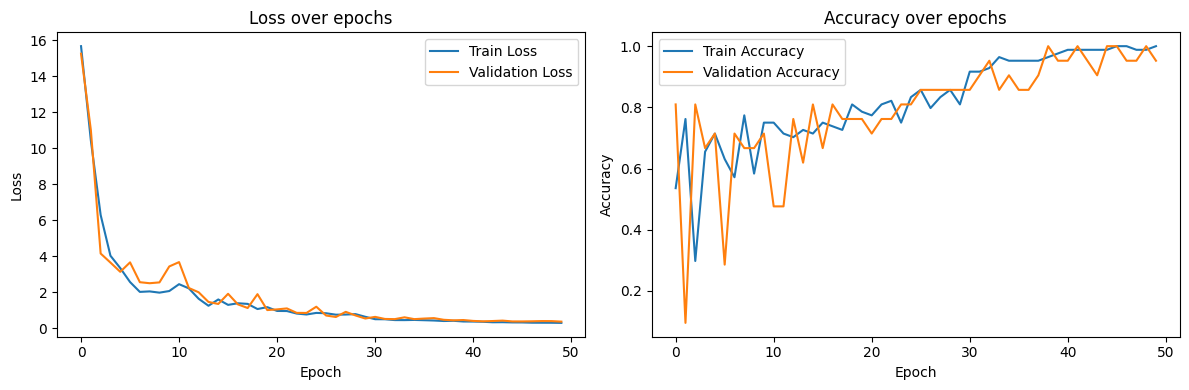

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
# Preprocess videos
video_jump = np.array([preprocess_video(vp) for vp in jump['video_path']])

angle_jump = jump[['hip_knee_angle', 'shoulder_hip_angle', 'shoulder_angle', 'elbow_angle','avg_hip_angle', 'avg_shoulder_angle', 'avg_knee_angle']].values


# Convert the scores to a numpy array
y_jump = jump['score'].values
y_adjusted_jump = y_jump-1

In [90]:
video_jump_train, video_jump_test, angle_jump_train, angle_jump_test, jump_train, jump_test = train_test_split(video_jump, angle_jump, y_adjusted_jump, test_size=0.2, random_state=42)

In [91]:
num_frames = video_jump_train.shape[1]
frame_height = video_jump_train.shape[2]
frame_width = video_jump_train.shape[3]
num_channels = video_jump_train.shape[4]
num_angles = angle_jump_train.shape[1]

In [92]:
video_jump_train[0].shape

(30, 64, 64, 3)

In [93]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))
x = Conv3D(32, (3, 3, 3), activation='relu')(video_input)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

In [94]:
# Angles branch
angles_input = Input(shape=(num_angles,))
y = Dense(32, activation='relu')(angles_input)

In [95]:
combined = Concatenate()([x, y])

In [96]:
# combined outputs
z = Dense(64, activation='relu')(combined)
score_output = Dense(3, activation='softmax')(z)

In [97]:
model = Model(inputs=[video_input, angles_input], outputs=score_output)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit([video_jump_train, angle_jump_train], jump_train, validation_data=([video_jump_test, angle_jump_test], jump_test), epochs=50, batch_size=32)


# Evaluate the model
loss, accuracy  = model.evaluate([video_jump_test, angle_jump_test], jump_test)
predictions = model.predict([video_jump_test, angle_jump_test])


print("Accuracy: {:.4f}".format(accuracy))

Epoch 1/50
3/3 [==============================] - 32s 9s/step - loss: 20.0115 - accuracy: 0.4500 - val_loss: 3.0992 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 29s 9s/step - loss: 6.8603 - accuracy: 0.3500 - val_loss: 3.2230 - val_accuracy: 0.3500
Epoch 3/50
3/3 [==============================] - 29s 9s/step - loss: 4.9699 - accuracy: 0.4750 - val_loss: 2.3281 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 28s 9s/step - loss: 4.8877 - accuracy: 0.5250 - val_loss: 2.2794 - val_accuracy: 0.7000
Epoch 5/50
3/3 [==============================] - 28s 8s/step - loss: 4.1882 - accuracy: 0.5875 - val_loss: 3.9595 - val_accuracy: 0.3500
Epoch 6/50
3/3 [==============================] - 29s 9s/step - loss: 3.4624 - accuracy: 0.3875 - val_loss: 1.2198 - val_accuracy: 0.7000
Epoch 7/50
3/3 [==============================] - 29s 9s/step - loss: 1.4179 - accuracy: 0.5875 - val_loss: 0.9208 - val_accuracy: 0.6500
Epoch 8/50
3/3 [=================

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()